UPLOAD TENSORS TO COLAB USING CELL BELOW

In [ ]:
import pickle
import random
import string
import tensorflow as tf
import re
from google.colab import files
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import keras_nlp
upload = files.upload()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.8 MB/s eta 0:00:00


In [2]:
train_input = pickle.load(open("DS_5_train_input", 'rb'))
train_output = pickle.load(open("DS_5_train_output", 'rb'))
for i in range(len(train_output)):
  train_output[i] = "[start] " + train_output[i] + "[end]"

NameError: ignored

CREATE VALIDATION SET

In [1]:
validation = []
temp = list(zip(train_input, train_output))
random.Random(6000).shuffle(temp)
train_input, train_output = zip(*temp)
train_input, train_output = list(train_input), list(train_output)
num_val_samples = int(0.2 * len(train_input))
val_in = train_input[-num_val_samples:]
val_out = train_output[-num_val_samples:]
train_in = train_input[:len(train_input) - num_val_samples]
train_out = train_output[:len(train_output) - num_val_samples]

print(len(train_in), len(train_out), len(val_in), len(val_out))
print(type(train_in[1000]))

NameError: ignored

USE STANDARDIZATION TO CREATE SOURCE AND TARGET VOCABULARIES USING TEXTVECTORIZATION LAYER

In [ ]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
def custom_standardization(input_string): 
 lowercase = tf.strings.lower(input_string) 
 return tf.strings.regex_replace( 
 lowercase, f"[{re.escape(strip_chars)}]", "")

In [ ]:
vocab_size = 500
sequence_length = 80

source_vectorization = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1,
    standardize = custom_standardization
)
source_vectorization.adapt(train_in)
target_vectorization.adapt(train_out)

CREATE DATASET WITH SEQ2SEQ FORMATTING

In [ ]:
def format_dataset(data_in, data_out):
  data_in = source_vectorization(data_in)
  data_out = target_vectorization(data_out)
  return ({
      "input_lang": data_in,
      "output_lang" : data_out[:, :-1],
  }, data_out[:, 1:])

def make_dataset(data_in, data_out, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((data_in, data_out))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset, num_parallel_calls = 4)
  return dataset.shuffle(6001).prefetch(16).cache()

In [ ]:
batch_size = 32
train_ds = make_dataset(train_in, train_out, batch_size)
val_ds = make_dataset(val_in, val_out, batch_size)

In [ ]:
for inputs, targets in train_ds.take(1):
  print(f"inputs['input_lang'].shape: {inputs['input_lang'].shape}")
  print(f"inputs['output_lang'].shape: {inputs['output_lang'].shape}")
  print(f"targets.shape: {targets.shape}")

inputs['input_lang'].shape: (32, 80)
inputs['output_lang'].shape: (32, 80)
targets.shape: (32, 80)


CREATE ENCODER/DECODER ARCHITECTURE USING TRANSFORMER CLASS

In [ ]:
embed_dim = 64
dense_dim = 256
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input_lang")
x = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, sequence_length, embed_dim)(encoder_inputs)
encoder_outputs = keras_nlp.layers.TransformerEncoder(dense_dim, num_heads)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output_lang")
x = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, sequence_length, embed_dim)(decoder_inputs)
x = keras_nlp.layers.TransformerDecoder(dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("636Project.keras",
                                    save_best_only=True,
                                    monitor="val_loss")
                                    
]
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=callbacks)

Epoch 1/200
125/125 [==============================] - 17s 36ms/step - loss: 2.6404 - accuracy: 0.2543 - val_loss: 1.7928 - val_accuracy: 0.3490
Epoch 2/200
125/125 [==============================] - 3s 20ms/step - loss: 1.8296 - accuracy: 0.3328 - val_loss: 1.6007 - val_accuracy: 0.3796
Epoch 3/200
125/125 [==============================] - 3s 20ms/step - loss: 1.6893 - accuracy: 0.3645 - val_loss: 1.5001 - val_accuracy: 0.4048
Epoch 4/200
125/125 [==============================] - 3s 20ms/step - loss: 1.6154 - accuracy: 0.3835 - val_loss: 1.4373 - val_accuracy: 0.4233
Epoch 5/200
125/125 [==============================] - 3s 22ms/step - loss: 1.5632 - accuracy: 0.3984 - val_loss: 1.4851 - val_accuracy: 0.4160
Epoch 6/200
125/125 [==============================] - 3s 21ms/step - loss: 1.5192 - accuracy: 0.4120 - val_loss: 1.4060 - val_accuracy: 0.4409
Epoch 7/200
125/125 [==============================] - 3s 21ms/step - loss: 1.4852 - accuracy: 0.4232 - val_loss: 1.3387 - val_accuracy

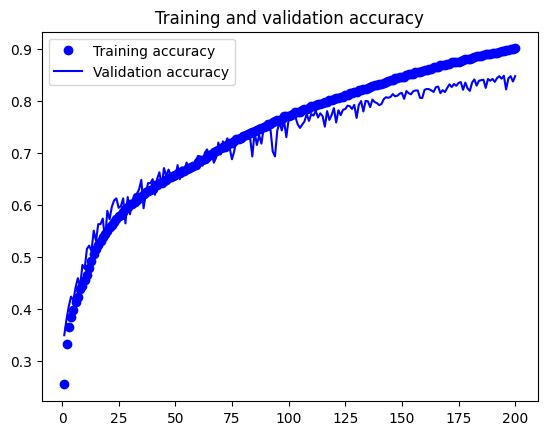

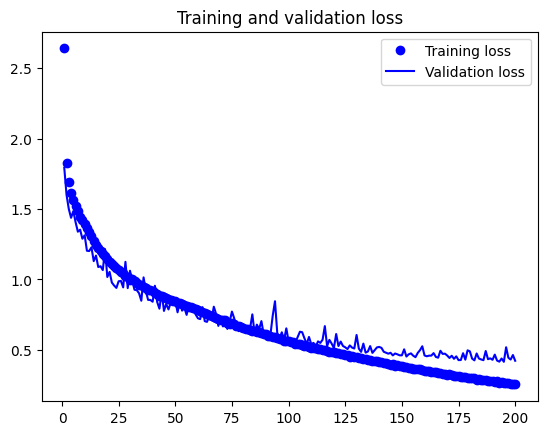

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

DECODE SENTENCE USING TOKEN SAMPLING (REMOVE START AND END TOKENS)

In [ ]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 80

def decode_sequence(input_sentence, model):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-5]

LOAD MODEL HERE

In [ ]:
test_input = pickle.load(open("DS_5_test_input", 'rb'))

saved_model = keras.models.load_model(
    "636Project.keras")

In [ ]:
output_texts = []
for i in range(len(test_input))[500:]:
  input_sentence = test_input[i]
  output_sentence = decode_sequence(input_sentence, saved_model)
  output_texts.append(output_sentence)
  if i % 100 == 0:
    print(str(i) + " of " + str(len(test_input)) + ":-")
    print(input_sentence)
    print(output_sentence)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

500 of 5000:-
a g a g a g c d c d c e a h c e a h b e a h a h c f c g a k a h c f c d c d b f c e b e b d b g 
c d c d a g d e c e c e b e c f c g c f c d c f a k l m ed c d a h j ee ef b e a h k eg eh b e a h j ei ej b g a h ek el a h i em a d g f fd b g a g fe ff 
600 of 5000:-
a i a d b g a d b f c e a g a j a e a h b d c e b g a f a h c e a e c f c g a e b g b g a e b d c e 
b g b f c d a d e f a e g a e h b e c d b f a d k l c e c f a e ee b g c g a h ef eg eh b g a h ed ei ej a j j m ek b e a e em a g el fd a d i fe c e a i e ff fg 
700 of 5000:-
a k b e a i a e a e b d a d b d b g a j a e c f c d a f b g b g 
b e b d a e e b d a d f g a e h c e c f c f a f k l b g b g a d ed ee a j j m ef a e eg a i d j eh 
800 of 5000:-
a i b e b e a k c d a h c e a k b g a e a d c g c d a d b f a d b f a e c g 
b e b e c d c e b g c d c d a d i j a k h k a e l a k g m b d b f c e a f ef eg a d ee eh a h g ed ei a i d e ej 
900 of 5000:-
a h c e a f b f a j a e b g a i b f b d c d b e a h b g a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1000 of 5000:-
a k a e b d a g b f a k a i a h c d a h b g b d c g a e b f c g a e a k b g b d c g 
b d a e d b f c d b g b d a h g h i c d b g a e l a h j k m b g a e ee b d c g a k eg eh c g a k ei ej a i ed ef ek a g e el a k f em 
1100 of 5000:-
a k b g a i a g c g a e a g a f b e a i b f a k b e a f b f a k b f b d a e a f b g b g b f a d c g a g c g c g c e 
b g c g b e b f b f b f b f b f a k j k a k i l a e m b f b d a e ef a f ee eg a i h ed eh a g g f ei b d a g ej ek a g f el c g c g c g a d fe ff a e fg a i f em fd fh 
1200 of 5000:-
a d c e a f a e a h a g a d c g a f a g b e a g a e b d c e b f a e c d b f a e b e c f 
c e c g c f b e b d a g g h a e i a f f j a e k b d a g l m a e ed a g e ee c d b e a f eg eh b e a h ef ei ej c e a f ek el a d d em 
1300 of 5000:-
a e a f b d a i a g b g a f a f c e b g a g c d c g a i a f a e b e c g b e b g a d a g c d b d b f 
b d b f c e b g c g a f g h a f f i a g e j c d b e b f a e ed b g a i m ee ef b d c e b f c d a d ej ek a g

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1500 of 5000:-
a e a h a h b g a d b d c d a d b d b f a k a d c e a k b f a f a g c f b e a e c e c g c g 
b g b d c d a d e f b d a h d g h b d c f a k j k b f c f b e a f ed ee c e a g ef eg c e a e ei a f eh ej a k m ek a k l el c g a h i em fd a e fe 
1600 of 5000:-
a k a e a i a f b f c g b e a g b d a f c e b g a k b f a f c e b f 
b f c f b e a g e f b d a i d g h a e i c e b g a k k l b f c e b f a f ee ef a k ed eg a g m eh a k j ei 
1700 of 5000:-
a d a h a e b g a j c e a k a d c d c g a k c f c f b e c d b g 
b e c g c d c g c f a d g h c f a k i j a k f k a j d e l a e m b e c d a h ed ee ef b g a d eg eh 
1800 of 5000:-
a h a k a f a g c f b f b g b e b f a h b e a j c d c g b g c d 
c g b f a f d e b e b f a g g h a k f i b e b g c d c g b d a j m ed ee c d a h l ef eg a h j k eh 
1900 of 5000:-
a h b e c e a i c g b d a e a i b f a j b g a j c g c g c f c e b f 
c e b e c g b d b f b g c g c f c e a j j k l a i h i m c f a i g ed ee a i f e ef b f a h eg eh b f a h d e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2000 of 5000:-
a g a g a e a i a d c e b d c e a e a g c g a d b e b g b f c f 
c e b d a e d e c e c g a e h a i d g i b d b g a e l b f a g m ed a e ee a i j k ef c f a g eg eh 
2100 of 5000:-
a d b f a d a f a j c g b f c d a g a f b e b g a i c f b g b e a d c f b d 
b f c f b g c f a j e f g b e b g a d i j b f c g b f c d a i m ed ee a g l ef a j f k eg b d a d eh ei a d d ej 
2200 of 5000:-
a j a g b f b g a f a i a g a d c f a k a g b e b e a i a k b e b f a k a e c f a j a k c f b d b d b d c d c e c f b e c e b g 
b f b f a g d e b g c e b e a k h i b f a e k b f b e c f a k ed ee c f b d c g a j eg eh ei a f ef ej b g a i l ek el c d a k em fd c e a k fe ff a i m fg c f a k fh fi 
2300 of 5000:-
a h c d c d a j c d a i c g b g c d a i b e a j a h c g a f a e c e b f b e a d a d c f c d a i c d b d c d c e b e 
c d c d c d c g b g a i f g h c e b e a d j k b e c f a e ed b d a f ee ef c d b d c f a d ei ej ek a j m eg eh el c d c d a e fd c e a h fd ff c e a i ff fg fh b e a 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2500 of 5000:-
a k a g b e a k a h a e b e a d b e c e b f b e a f c d a j a j c d b f a g a g a f c e b f b e a d c g c f b f c e 
b e b e a e e b e a d f g c e b e a h i j b e a h k k l c f b f c d b g a f ef eg c e b e a f ei ej c f a d ek el a j ee eh em c f a g fd fe b e a j ed ff fg a k m fh c 
2600 of 5000:-
a h b d b g a d c d a g b f a d a g c f c f a g a e c e a i c f c e c e 
b d b d c d b f c f c f a g h i c e a g j k a f g l c e c e c e a i ed ee ef a e eg a d m eh a g f ei a h d e ej 
2700 of 5000:-
a k a g a f a i b e a g a i b e a e c e b e b d c g c d a h c d c g a g b e c f c e 
b e b e c e a e f a e g b e c d a i h i d j a e k c g a i d l m c d c d b g c f a g eg eh c f a h ef ei ej a g ee ek a g ed el 
2800 of 5000:-
a j a d a e a h c f b g a i b e a i b f b d b g b d b g a e b d c e 
c f b e b g b d b f b d a i g h i b d a i f j k a e l a h d e m b g b d a e ef a g ee eg c e a j ed eh ei 
2900 of 5000:-
a f a j c e a d a g a k b f a d c e c e b d a d a k c f a e b 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3000 of 5000:-
a d a g a i b e a k b g c g b e a k a f a h b d a g b g b d c e c f b g c d 
b e b g c g a k e f b g a i d g h b f b d b g a d k l c e a h j m ed c f a k ee ef b g a f eg eh a g i ei c d a d ej ek 
3100 of 5000:-
a k c g a h a j c d a j c d b d c g a f c e a d c g a e a g c f a e a j b d c d b g a k c e b g b e 
c g c d c d b d c g a j f g h c f a e j a j e i k c g a e m c f b d b d c d a j ef eg eh a g ee ei a e ej a g ed ek c e b g a k em fd b e a k el fe ff a h l fg a k d fh 
3200 of 5000:-
a d a j b e a f c d c e a f c e a g a j a d c d a e c d a d a g b d c d c e a e b d c g a e c d 
b e c d c f a f e f c e c d a e i c d c e a d k l b d a d m ed c e a d ee ef a j j eg b e c g a d ei ej a j eh ek a f g h el c d a e fd a d em fe a d g ff 
3300 of 5000:-
a g b e a h b d c e a d a f a h c f a h a g a e c e b d b e c d b d c e a j c e b e b d 
b e b e c d c f c e b e a g h i b d a e k a h g j l b d c e a h m ed ee c e b e c f b e a j eh ei ej a h ef eg ek a d f el a d e 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3500 of 5000:-
a i a g b d a d b f a i a h a i a f a e b g c e b g c f c e c g a j c d b g b d a d c g c g b d a f b d a d a g b d c g c e 
b g b f b d c e a g f g b e a k h i c f c e a i j k l c g c d a i m ed ee b d b d a g eg eh c g a d ei ej b g b f a d el em a g ek fd b d a e ff a i ef fe fg b d c d a d 
3600 of 5000:-
a h a e c g c e a j a d a d c e b e c e a g a k b g c d a f c e a g a g b g b g c f b e 
c e a e d c e c e b e a d g h c e a d i j b g c f a g l m b g c e b g a g ef eg b f a g eh ei a k ee ej a k ed ek a j f i el b e a h f em fd 
3700 of 5000:-
a f a g a e a e c f a e a h b f a d c g a j a f c d c e b d c e c e b e 
c f b e c d c g b e a d g h c e a f i j a f f k c e b e a j l m ed c e a h e ee ef a g d eg b e a g eh ei 
3800 of 5000:-
a i a g b f a k c g a k c f a h a d a f b g b e c e a i b e c f a e c d a j b d b f a f c e c g b d c f 
b f c g c f b f b e c e a g h i a d g j c e b f c e a i l m ed a d k ee a k f ef b d b f b f c e a j ei ej ek c g a j eh el em a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4000 of 5000:-
a j a k a e a d a i a h c d b e b d b f a d a i c f a g b f b g b e a k b g c f b g b g c g c g 
b d c d b e a i d e f b d c f b f b g c e b g a i k l m b f a g ed ee a d j ef a f i eg b f a k eh ei a d h ej a g h ek b g a k el em c g c g a j fd fe ff 
4100 of 5000:-
a d a j c f a d a f c d b g c f c g a d c e a d a f b g c e c e 
c f c g b d a d e f c f a d g h c g a j d i j c e b g c e a f m ed c e a d ee ef a d l eg a d k eh 
4200 of 5000:-
a i a k a d b g b d a d c d a e b f a d a e c e a g c g a g c d c f a d b g a e a e c g 
b g b d a d d e c d a k f g b d a e i c e c g a e l c g c f a d ed ee a g m ef a d k eg a g j eh a e ei b d a e ek a e el a i d ej em 
4300 of 5000:-
a k a f c e c e a e a d a g c g b f a e a k a d b g b e a g c g b f 
c e c e a f d e c g b f a e h b g b d a k j k c e a g l m b f a e ee a k ed ef a d i eg a g g eh a k e ei 
4400 of 5000:-
a i b f b e a g a g c e a i c f a i b f a e b d c d c d a e b e 
b f b e c g c f b f b d c d a e j a i h i 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4500 of 5000:-
a i c d c e a e a d a g a j b e a g b e b d a h c e b d b e b g b e 
c e c d b e b e a g f g b e b d c e b d a h j k l a j h i m b e a g ed ee b e a d ef eg a e eh a i d e ei 
4600 of 5000:-
a h a f a e c g a d a f a d a h b g a d a e b d c e c g c d a h c e c e b g a f b f b e c f a f a e a e c e b g 
c f a e d b d b d a e g c e a h g h i c d a e k a f k l c d c e c e c f a h ee ef eg a d ed eh a g m ei b f a g ej ek a f d el c f a e fd c e b e a f ff fg b g a e fi a
4700 of 5000:-
a h a j a i a k c d c e a d a f c d c e a e b f b f b e b d a i b d a f b d c g a e c f a k b f a f a f b f b g b d 
c d c e c f a d e f a k d g c e a e i b f a d j k b f a i h l m b e b d b f c f b d a d eh ei a d eg ej c f b f b f b g a f fd fe b g a f ff fg a k em fh a k el fi a i 
4800 of 5000:-
a i c g a f b g a i c e a e b f a h c d a h a e c f b f c d a g b e c d a f c f c f 
c g b f c e b f c d c f a e i a h g h j c f b d a h k l m c f a e ee a i f ed ef b f c f c f a d ei ej a i eg e

In [ ]:
pickle.dump(output_texts, open("output_texts", 'wb'))

EVALUATE MODEL USING DEFAULT ACCURACY METHOD (RUN THIS LINE)

In [ ]:
print(f"Test acc: {saved_model.evaluate(val_ds)[1]:.3f}")

32/32 [==============================] - 0s 10ms/step - loss: 0.1919 - accuracy: 0.9008
Test acc: 0.901


Notes: The output_texts submitted do not match exactly with those produced by the model submitted. I made a significant improvement to my model just now that boosted my model accuracy by around 5%, but did not have time to create the output_texts with said model, instead using the previous model with an accuracy of 85%. The reason I was not able to submit that model was because it used custom classes for the Transformer architecture that I could not attach, as opposed to the model attached below that will run without any modifications. YOU CAN CREATE THE MODEL THAT PRODUCED THE OUTPUT TEXTS SUBMITTED BY RUNNING ALL CELLS BELOW.

# OLD MODEL CREATION

CREATE KERAS TRANSFORMER ARCHITECTURE

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
embed_dim = 64
dense_dim = 256
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input_lang")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output_lang")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("636ProjectOLD.keras",
                                    save_best_only=True,
                                    monitor="val_loss")
                                    
]
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=callbacks)

In [ ]:
saved_model = keras.models.load_model(
    "636ProjectOLD.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding,
                    "TransformerDecoder": TransformerDecoder})


In [ ]:
print(f"Test acc: {saved_model.evaluate(val_ds)[1]:.3f}")